In [1]:
import sys; sys.path.append("..")
from critical_ai_2026 import *


In [2]:
from hashstash import HashStash
import pandas as pd
from tqdm import tqdm
STASH_EMO_ANNO = HashStash(os.path.abspath("../data/emogens2"))
# STASH_EMO_ANNO.clear()
STASH_EMO_ANNO

Config,Param,Value
Path,Root Dir,/Users/ryan/github/critical-ai-2026/data/emogens2
,Filename,data.db
Engine,Engine,lmdb
,Serializer,hashstash
,Compress,lz4
,B64,True
Stats,Len,3420


In [3]:
PATH_EMOSYS = os.path.abspath("../data/emotion_classifications.json")
EMOSYS_OK = [
    # "Plutchik 1980",
    "Parrott 2001",
    "Robinson 2009",
]

def get_emosys_options(emosys_ok = EMOSYS_OK):
    df = pd.read_json("../data/emotion_classifications.json")
    lines=[]
    emosys2options = {}
    gby = ["emotion_system_name", "emotion_system_year"]
    for (emosysname, emosysyear), gdf in df.groupby(gby):
        emosys = f'{emosysname} {emosysyear}'
        if emosys not in emosys_ok:
            continue
        opts = {}
        for emocat, ggdf in gdf.groupby("emotion_category"):
            emowords = list(ggdf.emotion_word.unique())[:100]
            opts[emocat.upper()] = emowords
        
        if len(opts) > 2:
            emosys2options[emosys] = opts

    return emosys2options


In [4]:


def emosys2prompt(emocat2words):
    system_prompt = """Read the following passage and choose which emotion categories
are represented in (depicted in, evoked by, etc) the passage.

Here are the categories from which you must choose and the 
words associated with them:

Return your answer in a JSON dictionary. The keys are the 
categories that you have chosen (each string must be the exact 
match of the category chosen), and their values are lists of strings
matching the most indicative phrases from the passage for that category.
"""
    lines = system_prompt.split("\n")
    for emocat, words in emocat2words.items():
        lines.append(f"* {emocat.upper()} ({', '.join(words)})")
    return "\n".join(lines)



In [5]:
emosys2options = get_emosys_options()
# emosys2options

In [6]:
def annotate_emotions(passage, model=DEFAULT_MODEL, verbose=True, **kwargs):
    dbkey = (passage,model)
    if dbkey in STASH_EMO_ANNO:
        out = STASH_EMO_ANNO[dbkey]
    else:
        out = {}
        for emosys,emocat2words in tqdm(emosys2options.items(), total=len(emosys2options), desc="Prompting for emotion annotations",disable=not verbose):
            prompt = emosys2prompt(emocat2words)
            data = generate_json(passage, system_prompt=prompt, model=model, max_tokens=1_000, verbose=False)
            if data:
                out[emosys] = data
        
        STASH_EMO_ANNO[dbkey] = out
    
    out2 = []

    def add(sysname, catname, egs):
        eg_opts = emosys2options.get(sysname,{}).get(catname,[])
        eg_opts_str = ", ".join(eg_opts[:5])
        for eg in egs:
            out2.append({
                "emosys":sysname,
                "emocat":catname,
                "emoopts":eg_opts_str,
                "eg":eg,
            })
    
    for emosys, emocat2words in out.items():
        for emocat, words in emocat2words.items():
            if isinstance(words, dict):
                for emocat2, words2 in words.items():
                    add(emosys, f"{emocat} > {emocat2}", words2)
            else:
                add(emosys, emocat, words)
    odf = pd.DataFrame(out2)
    odf = odf[odf.emosys.isin(EMOSYS_OK)]
    return odf

In [7]:
annotate_emotions("Hello bright and sunny day!")

,emosys,emocat,emoopts,eg
0,Parrott 2001,JOY,"joy, cheerfulness, zest, contentment, pride",bright and sunny day
3,Robinson 2009,POSITIVE - EVENT-RELATED,"gratitude, thankfulness, joy, elation, triumph",bright and sunny day


In [8]:
df_gen_completions = pd.read_csv("/Users/ryan/github/generative-formalism/data/data_as_in_paper/genai_rhyme_completions.csv.gz")
df_meta = pd.read_csv("/Users/ryan/github/generative-formalism/data/raw/corpus/chadwyck_corpus_metadata.csv.gz")
id2period = dict(zip(df_meta.id, df_meta.year.apply(lambda x: f"{int(x//100)*100}s")))
# id2period

In [9]:
def get_df_smpl(lim=10, min_lines=10):
    o = []
    gby = ["id_human","model","first_n_lines","id"]
    for i,(g,gdf) in enumerate(df_gen_completions.groupby(gby)):
        if len(o) >= (lim*3):
            break
        gdf2 = gdf.dropna(subset=["line_gen"])
        if len(gdf2) < min_lines:
            continue
        
        gd = dict(zip(gby, g))
        gd["period"] = id2period[gd["id_human"]]
        
        gdf0 = gdf[gdf.line_gen.isna()]
        poem_txt_init = gdf0.line_real.str.cat(sep="\n")
        poem_txt_human = gdf2.line_real.str.cat(sep="\n")
        poem_txt_gen = gdf2.line_gen.str.cat(sep="\n")

        num_lines_init = len(gdf0)
        # poem_txt_human = truncate_text(poem_txt_human, num_lines_init)
        # poem_txt_gen = truncate_text(poem_txt_gen, num_lines_init)
        
        o.append({
            **gd,
            "source":"prompt",
            "txt_trunc":poem_txt_init,
            "num_lines":len(gdf0),
        })
        o.append({
            **gd,
            "source":"human",
            "txt_trunc":poem_txt_human,
            "num_lines":len(gdf2),
        })
        o.append({
            **gd,
            "source":"genai",
            "txt_trunc":poem_txt_gen,
            "num_lines":len(gdf2),
        })
    return pd.DataFrame(o)



In [10]:
def annotate_emotion_mp(poem_txts, model=DEFAULT_MODEL, verbose=False, n_workers=None):
    """Annotate emotions for multiple poems in parallel using a thread pool."""
    from concurrent.futures import ThreadPoolExecutor, as_completed

    if n_workers is None:
        n_workers = min(4, len(poem_txts))

    results = [None] * len(poem_txts)

    def _annotate(idx_txt):
        idx, txt = idx_txt
        return idx, annotate_emotions(txt, model=model, verbose=False)

    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        futures = {executor.submit(_annotate, (i, txt)): i for i, txt in enumerate(poem_txts)}
        for future in tqdm(as_completed(futures), total=len(poem_txts), desc="Annotating poems", disable=not verbose):
            idx, df = future.result()
            results[idx] = df.assign(txt_trunc=poem_txts[idx])

    return pd.concat(results).reset_index(drop=True)

In [ ]:
df_smpl = get_df_smpl(lim=1000)
# df_smpl

In [12]:
odf = annotate_emotion_mp(
    df_smpl.txt_trunc.tolist(), 
    model="openai/gpt-3.5-turbo", 
    verbose=True, 
    n_workers=4
)
odf

Annotating poems: 100%|██████████| 3000/3000 [00:05<00:00, 520.76it/s] 


,emosys,emocat,emoopts,eg,txt_trunc
0,Parrott 2001,ANGER,"anger, irritability, exasperation, rage, disgust",submit to tyrant's rule,"Oh! you men of colour, wake to glory!\n Too..."
1,Parrott 2001,ANGER,"anger, irritability, exasperation, rage, disgust",starve in adversity's cold school,"Oh! you men of colour, wake to glory!\n Too..."
2,Robinson 2009,POSITIVE - SOCIAL,"charity, sympathy",glory,"Oh! you men of colour, wake to glory!\n Too..."
3,Robinson 2009,POSITIVE - SOCIAL,"charity, sympathy",claim your own,"Oh! you men of colour, wake to glory!\n Too..."
4,Robinson 2009,NEGATIVE - SOCIAL,"avarice, greed, miserliness, envy, jealousy",serfs of wealth,"Oh! you men of colour, wake to glory!\n Too..."
...,...,...,...,...,...
35201,Robinson 2009,POSITIVE - EVENT-RELATED,"gratitude, thankfulness, joy, elation, triumph",transient scenes,Dissolves as wisps of smoke in morning haze\nT...
35202,Robinson 2009,POSITIVE - EVENT-RELATED,"gratitude, thankfulness, joy, elation, triumph",moment caught,Dissolves as wisps of smoke in morning haze\nT...
35203,Robinson 2009,POSITIVE - EVENT-RELATED,"gratitude, thankfulness, joy, elation, triumph",steady flow,Dissolves as wisps of smoke in morning haze\nT...
35204,Robinson 2009,POSITIVE - EVENT-RELATED,"gratitude, thankfulness, joy, elation, triumph",life's journey,Dissolves as wisps of smoke in morning haze\nT...


In [13]:
# odf[["emocat","eg"]]

In [36]:
def get_stats(odf, df_smpl, include_period_or_prompt=True, max_cats=None):
    odf2 = odf.merge(df_smpl, on="txt_trunc", how="left").fillna("")
    gby = ["source","emosys","emocat","emoopts"]
    gby2 = ["source"]
    if include_period_or_prompt:
        gby2.append("period")
        gby.append("period")
    dfstat = odf2.groupby(gby).agg({"eg": "count"}).reset_index()

    def get_emo_str(row):
        emocat = row.emocat
        emosys = row.emosys
        emoopts = row.emoopts
        out = f"{emocat} ({emosys})"
        if emoopts:
            out += f"\n[{emoopts}]"
        return out

    dfstat["emo"] = dfstat.apply(get_emo_str, axis=1)
    dfstat["perc"] = dfstat.eg / dfstat.groupby(gby2).eg.transform("sum")

    avg_hum = dfstat.query("source == 'human'").groupby("emo").perc.sum().sort_index()
    avg_gen = dfstat.query("source == 'genai'").groupby("emo").perc.sum().sort_index()
    avg_diff = (avg_hum - avg_gen).fillna(0).sort_values(ascending=True)
    avg_diff_abs = avg_diff.abs()
    if max_cats is not None:
        top_cats = avg_diff_abs.sort_values(ascending=False).index.tolist()[:max_cats]
        dfstat = dfstat[dfstat.emo.isin(top_cats)]


    figdf = dfstat.copy().reset_index()
    if include_period_or_prompt:
        figdf["group"] = figdf.source + " (" + figdf.period + ")"
    else:
        figdf["group"] = figdf.source

    # top_cats = figdf.groupby("emo").eg.sum().sort_values(ascending=True).index.tolist()
    # if max_cats is not None:
    #     cats = top_cats[:max_cats]
    #     figdf = figdf[figdf.emo.isin(cats)]

    # cats = figdf.groupby("emo").perc.sum().sort_values(ascending=True).index.tolist()
    
    cats = avg_diff.sort_values(ascending=False).index.tolist()
    figdf["emo"] = pd.Categorical(figdf.emo, categories=cats)
    # figdf["perc_str"] = figdf.perc.apply(lambda x: f"{round(x*100,1)}%" if x > 0.01 else "")
    figdf["perc_str"] = figdf.perc.apply(lambda x: f"{int(round(x*100))}%" if x > 0.01 else "")
    figdf['perc']*=100
    figdf['source'] = figdf['source'].str.replace("human", "Poem")
    figdf['source'] = figdf['source'].str.replace("genai", "Completion")
    figdf['source'] = figdf['source'].str.replace("prompt", "Prompt")
    return figdf.sort_values("perc", ascending=False)
    

In [37]:
figdf = get_stats(odf, df_smpl, include_period_or_prompt=False, max_cats=10)
# figdf

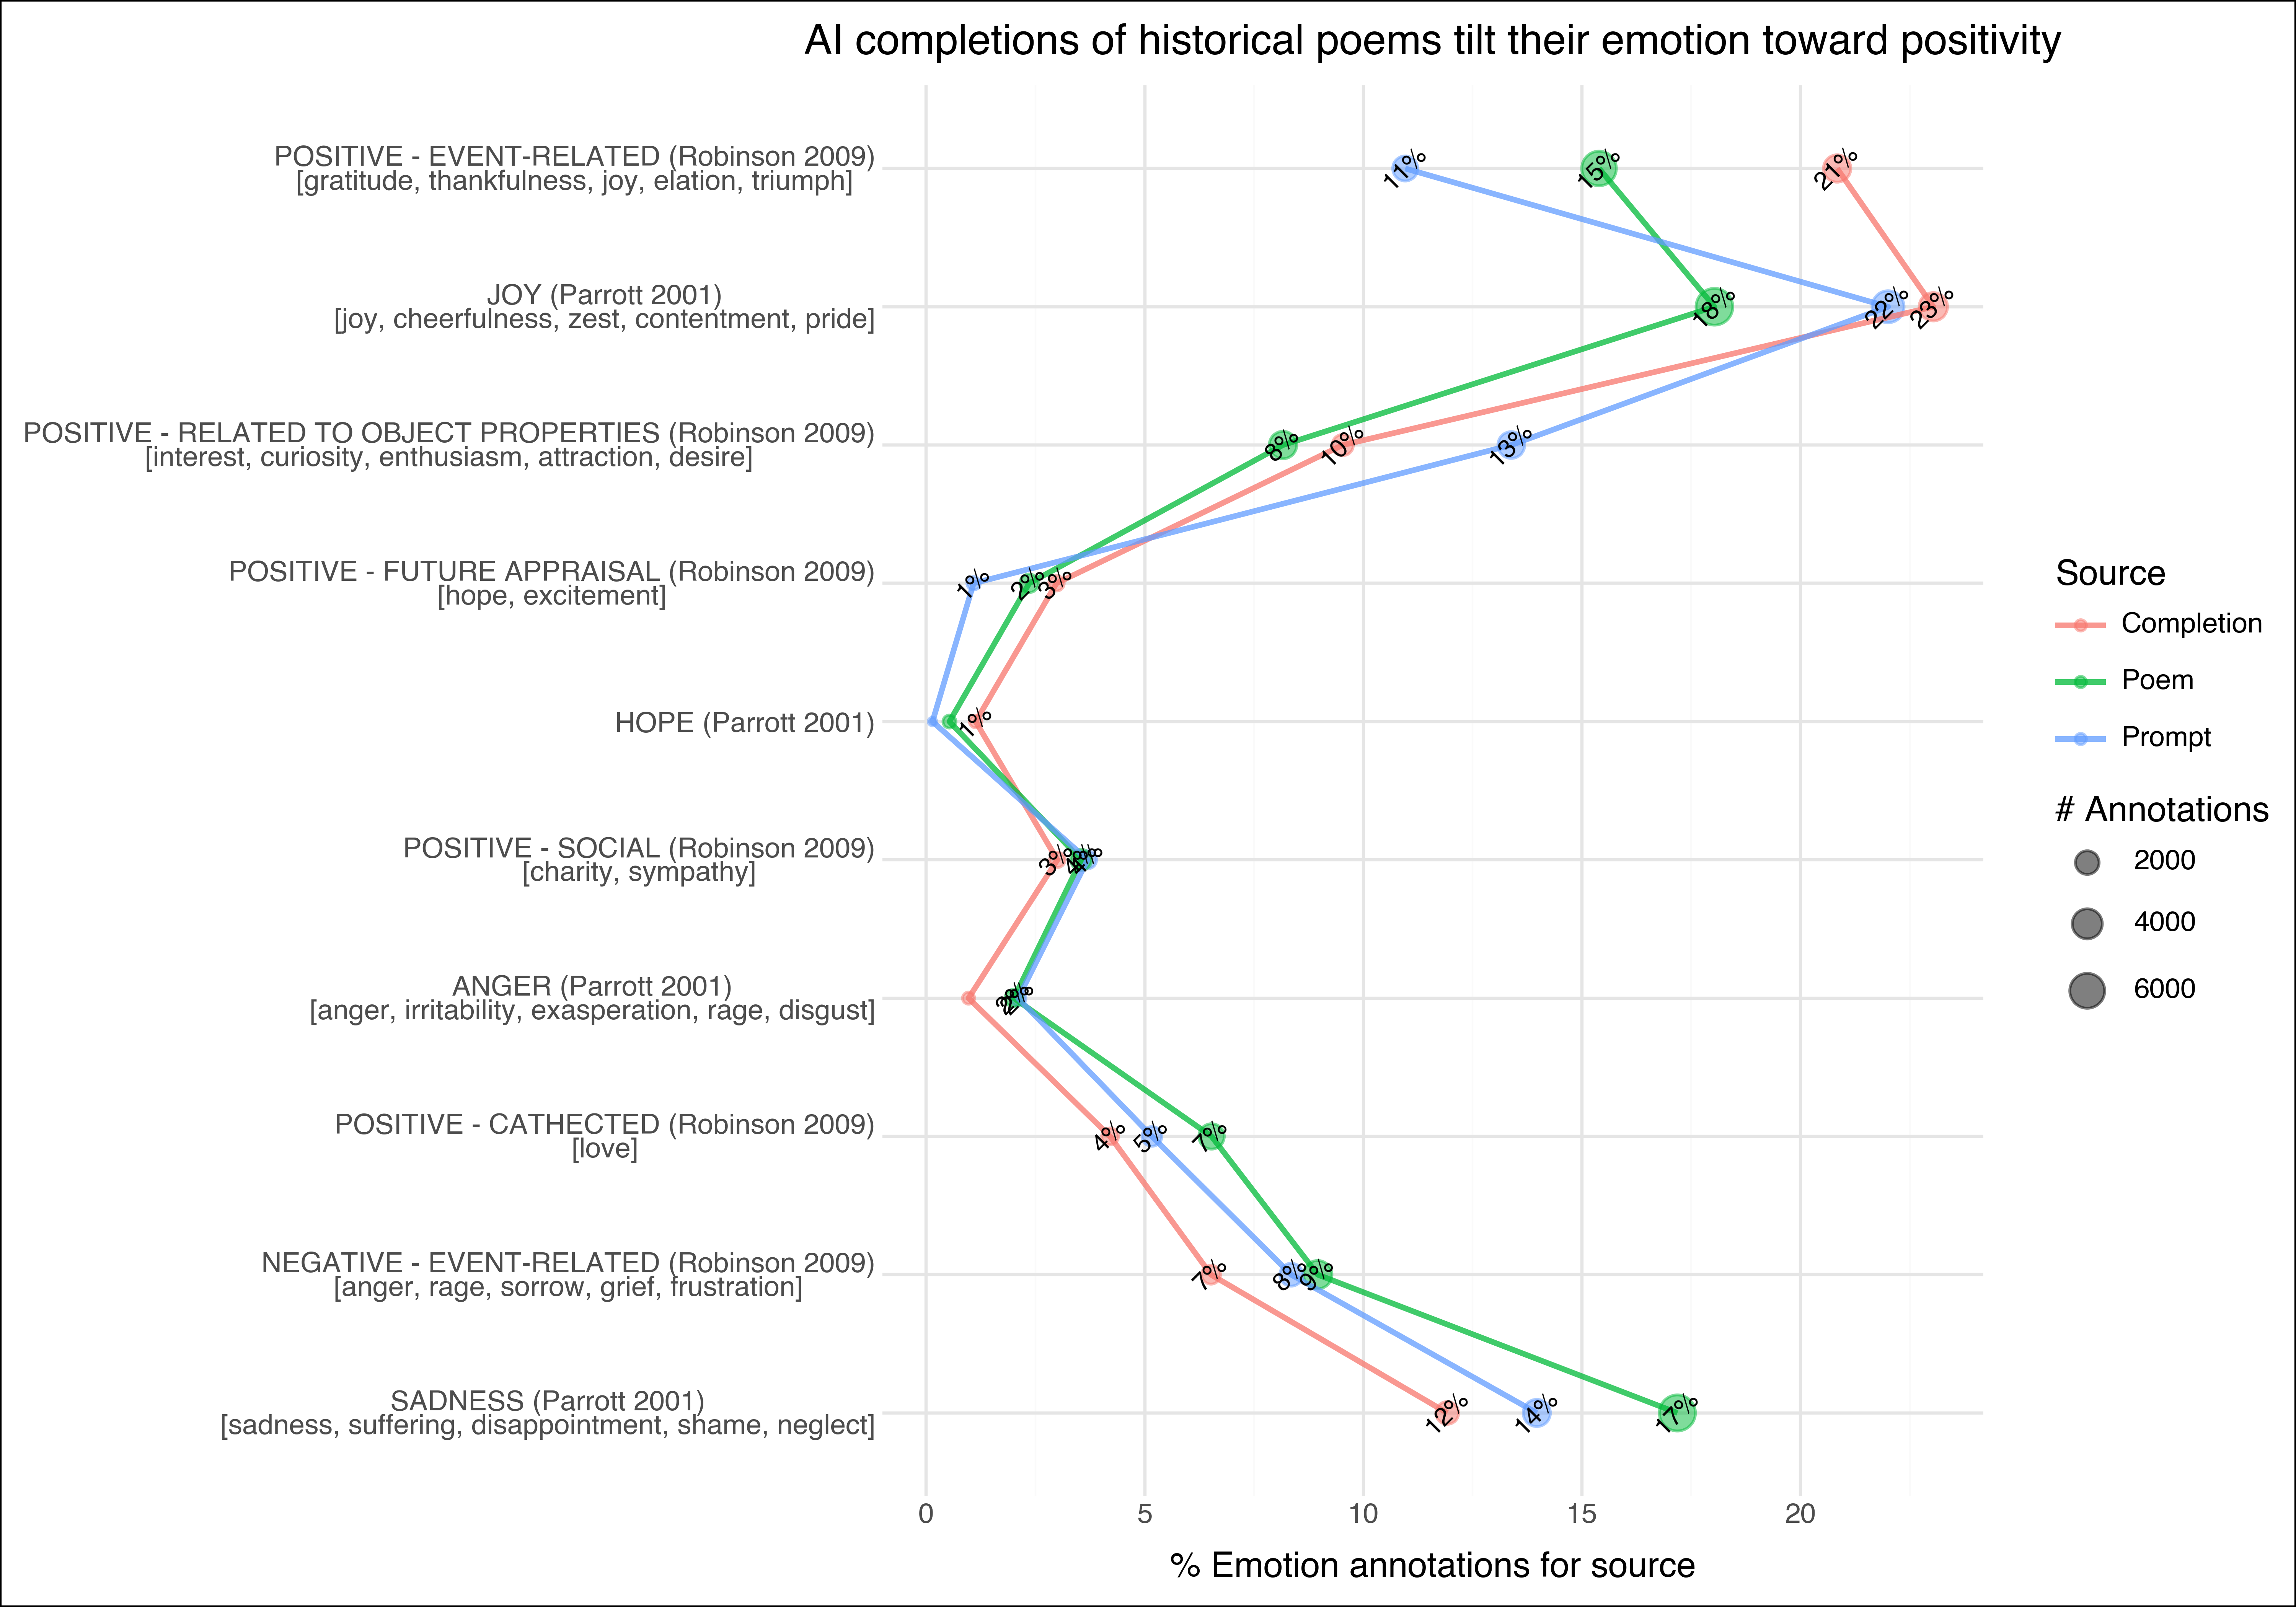

In [38]:
import plotnine as p9
p9.options.figure_size = (10, 7)
p9.options.dpi = 300
fig = (
    p9.ggplot(figdf, p9.aes(x="emo", y="perc")) 
    + p9.geom_point(p9.aes(color="source", size="eg"),alpha=0.5) 
    + p9.geom_line(p9.aes(group="source", color="source"), size=1, alpha=.75)
    # + p9.geom_smooth(p9.aes(linetype="source", group="source"), method="loess", span=0.5, se=False, size=.8)
    # + p9.facet_wrap("period",ncol=4)
    + p9.coord_flip()
    + p9.geom_text(p9.aes(label="perc_str"), size=8, angle=45, color="black") 
    + p9.theme_minimal()
    + p9.theme(
        plot_background=p9.element_rect(fill="white"),
        panel_background=p9.element_rect(fill="white"),
        # axis_text_y=p9.element_text(ha="right"),
        # axis_text_y=p9.element_text(ha="left")
    )
    # + p9.theme(legend_position="bottom")
    + p9.labs(
        y="% Emotion annotations for source",
        x="",
        color="Source",
        size="# Annotations",
        title="AI completions of historical poems tilt their emotion toward positivity"

    )
)
fig.save("fig.ai_poem_emotions.png")
fig
